In [28]:
import csv
# Работа с данными и визуализация
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.stats.api as sms
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil

%matplotlib inline

In [29]:
df = pd.read_csv("C:DataSet\\ab_data.csv", sep=',')
df.head(5)

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


Dataset at a glance

The dataset will be used for the analysis consists of 5 columns:

user_id: unique user ids 
timestamp: represents when a session starts for a user 
group: contains 2 different values as control and treatment 
landing_page: contains 2 different values as old_page and new_page 
converted: represents user behavior: if a user made a purchase (1) or not (0)

In [30]:
df.shape
df.info()

(294478, 5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [21]:
# Finding the number of duplicates user
user_duplicate = df['user_id'].value_counts()
users_multi = user_duplicate[user_duplicate > 1].count()
users_multi

1

In [22]:
#Check if the user ids are unique
df.user_id.nunique()
df.shape[0]

290584

290585

In [31]:
pd.crosstab(df['group'], df['landing_page'])

landing_page,new_page,old_page
group,,
control,1928,145274
treatment,145311,1965


In [32]:
# Removing the duplicates user
to_drop = user_duplicate[user_duplicate > 1].index
df = df[~df['user_id'].isin(to_drop)]

In [33]:
pd.crosstab(df['group'], df['landing_page'])

landing_page,new_page,old_page
group,,
control,1928,145274
treatment,145309,1965


<Axes: xlabel='converted', ylabel='count'>

[Text(0.5, 1.0, '# Conversion for Each Version'),
 Text(199.05882352941177, 0.5, 'Count')]

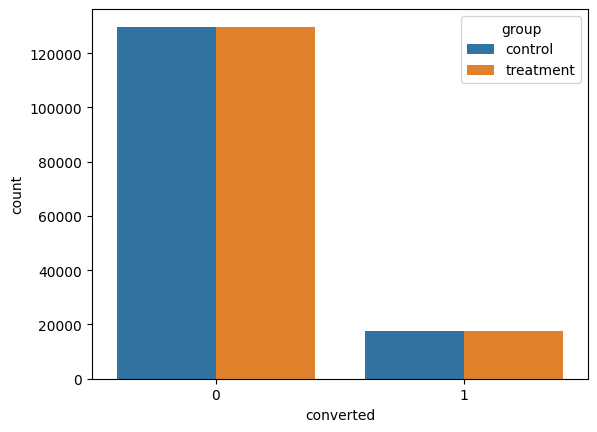

In [61]:

sns.countplot(x="converted", data=df, hue="group")
axes[1].set(title="# Conversion for Each Version", ylabel="Count")
plt.show()

Hypothesis

In [26]:
null_hypothesis = 'Perubahan Landing Page Tidak Berpengaruh Terhadap Converted'
alternate_hypothesis = 'Perubahan Landing Page Berpengaruh Terhadap Converted'

Sampling 
Выборка

In [34]:
# comparing two proportions
effect_size = sms.proportion_effectsize(0.13, 0.15)   
# solve for any one parameter of the power of a two sample z-test
required_n = sms.NormalIndPower().solve_power(effect_size, power=0.8,  alpha=0.05,ratio=1)                                                 
required_n = ceil(required_n)                                                   

print(required_n)

4720


In [45]:
control_sample = df[df['group'] == 'control'].sample(n=required_n, random_state=22)
treatment_sample = df[df['group'] == 'treatment'].sample(n=required_n, random_state=22)

ab_test = pd.concat([control_sample, treatment_sample], axis=0)
ab_test.reset_index(drop=True, inplace=True)
ab_test

,user_id,timestamp,group,landing_page,converted
0,644179,2017-01-16 04:15:36.663685,control,old_page,0
1,729672,2017-01-20 19:04:10.409185,control,old_page,0
2,866186,2017-01-09 02:56:47.675707,control,old_page,0
3,884303,2017-01-18 04:49:04.225284,control,old_page,0
4,882576,2017-01-15 13:36:49.854723,control,old_page,0
...,...,...,...,...,...
9435,660299,2017-01-20 06:34:55.913919,treatment,new_page,0
9436,687992,2017-01-11 14:50:29.884664,treatment,new_page,0
9437,847474,2017-01-14 20:38:27.645221,treatment,new_page,0
9438,868589,2017-01-02 13:46:40.314864,treatment,new_page,0


Testing the Hypothesis

In [39]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint
control_results = ab_test[ab_test['group'] == 'control']['converted']
treatment_results = ab_test[ab_test['group'] == 'treatment']['converted']
n_con = control_results.count()
n_treat = treatment_results.count()
successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

p_value = f'p-value: {pval:.3f}'

z statistic: -0.03
p-value: 0.975
ci 95% for control group: [0.110, 0.128]
ci 95% for treatment group: [0.110, 0.128]


In [40]:
if p_value < '0.05':
    print('the null hypothesis should be rejected and accept alternate hypothesis')
    print(alternate_hypothesis)
else:
    print('the alternate hypothesis should be rejected and accept null hypothesis')
    print(null_hypothesis)

the alternate hypothesis should be rejected and accept null hypothesis
Perubahan Landing Page Tidak Berpengaruh Terhadap Converted
